# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 
## Homework 3 - Bayesian Analysis



**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, & Chris Tanner 


<hr style="height:2pt">

### Homework 3 is due March 5th

In [1]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment, please follow the instructions on Canvas.
- Please restart the kernel and run the entire notebook again before you submit.

<hr style="height:2pt">

### Please use the libraries below:

In [2]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
%matplotlib inline 
from datetime import datetime as dt
from scipy.special import expit


<hr style="height:2pt">

### Contraceptive Usage by Bangladeshi Women

In the second part of this assignment, you are provided with data sets `dataset_2_train.csv` and `dataset_2_test.csv`containing details of contraceptive usage by 1934 Bangladeshi women. There are four attributes for each woman, along with a label indicating if she uses contraceptives. The attributes include
* district: identifying code for the district the woman lives in
* urban: type of region of residence
* living.children: number of living children
* age-mean: age of the woman (in years, centered around mean)

The women are grouped into 60 districts. The task is to build a classification model that can predict if a given woman uses contraceptives.


### Part A: Bayesian Logistic Regression

The first model we will fit to the contraceptives data is a varying-intercept logistic regression model, where the intercept varies by district.

Prior distribution:

$\beta_{0j} \sim N(\mu_0,\sigma_0^2),$ with $\mu_0 \sim N(0,10000)$ and $\frac{1}{\sigma^2_0} \sim \text{Gamma}(0.1,0.1)$.

$\beta_1 \sim N(0,10000)$, $\beta_2\sim N(0,10000)$, $\beta_3 \sim N(0,10000)$

Model for data:

$Y_{ij} \sim \text{Bernoulli}(p_{ij})$

$\text{logit}\:p_{ij} = \beta_{0j} + \beta_1 \times \text{urban} + \beta_2 \times \text{living.children} + \beta_3 \times \text{age-mean}$,

where $Y_{ij}$ is 1 if woman $i$ in district $j$ uses contraceptives, and 0 otherwise, and where $i \in \{1,...,N\}$ and $j \in \{1,...,J\}$. $N$ is the number of observations in the data, and $J$ is the number of districts. The above notation assumes $N(\mu, \sigma^2)$ is a Normal distribution with mean $\mu$ and variance $\sigma^2$.

##### **A1**

As a preprocessing step, map the district number 61 to the number 54 so that the districts are in order. Also, re-name district 60 to be district 0 so that the districts are numbered 0 through 59. **We use this numbering throughout the homework, and will grade using these district numbers**

In [66]:
#read the data
traindata = pd.read_csv('Data/dataset_2_train.csv', sep = ',' )
testdata = pd.read_csv('Data/dataset_2_test.csv', sep = ',' )

#change district numbers
traindata["district"].replace({61: 54, 60: 0}, inplace=True)
testdata["district"].replace({61: 54, 60: 0}, inplace=True)

#print unique values
print(sorted(traindata.district.unique()))
print(sorted(testdata.district.unique()))
districts = testdata.district.unique()
print(traindata.head(5))
print(testdata.head(5))
traindata.describe()
print('Average Use of Contraceptive for train data is ' +str(sum(traindata['contraceptive_use'])/len(traindata)))
print('Average Use of Contraceptive for test data is ' +str(sum(testdata['contraceptive_use'])/len(testdata)))
cuse = 0
for d in districts:
    distdata = traindata[(traindata['district'] == d)]
    u = (distdata[(distdata['contraceptive_use'] == 1)])
    cuse = cuse + sum(u['contraceptive_use'])
print(str(cuse/len(traindata)))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
   district  urban  living.children  age_mean  contraceptive_use
0        35      0                4    2.4400                  0
1        22      0                2   -1.5599                  1
2        29      0                2   -8.5599                  1
3         5      0                3   -4.5599                  1
4        34      1                4    8.4400                  0
   district  urban  living.children  age_mean  contraceptive_use
0         1      1                4   18.4400                  0
1         1      1

##### **A2**

First, we'll verify that pymc3 can recover the hidden parameter values. To do so, we'll hard-code known values and simulate data from the model, then using that data we'll check if pymc3 can get back the parameters we hard-coded. If it does, we'll have hope that it can get the hidden parameter values that generated the real data.

Use the following hard-coded values:  
$\mu_0 = 2$

$\sigma^2_0 = 1$

$\beta_{0j} \sim N(\mu_0,\sigma_0^2)$ for all sixty districts

$\beta_1 = 4$

$\beta_2 = -3$

$\beta_3 = -2$

**Verify that these parameters give an overall average of 46 to 48 percent of subjects using contraceptives**

In [67]:
#your code here
from scipy.stats import bernoulli
np.random.seed(109)

mu, sigma = 2, 1
beta = [4, -3, -2]

size = 1000

# try with all simulated data
alpha = np.random.normal(mu,sigma,60)
X1 = np.linspace(0, 1, size)
X2 = np.linspace(1, 4, size)
X3 = np.linspace(-13.56, 19.44, size)

Ytot = 0
for i in alpha:
  pi = expit(i + beta[0]*X1 + beta[1]*X2 + beta[2]*X3 + sigma)
  np.set_printoptions(formatter={'float_kind':'{:f}'.format})
  Y = np.round(pi)
  Ytot = Ytot + Y
print (str(sum(Ytot)/(size*60)))
    
    

# try with training data and variable intercept
Ytot = 0
d = 0
# try with real data
for i in alpha:
  distdata = traindata[(traindata['district'] == d)]
  X1 = distdata['urban'] 
  X2 = distdata['living.children'] 
  X3 = distdata['age_mean'] 
  pi = expit(i + beta[0]*X1 + beta[1]*X2 + beta[2]*X3 + sigma)
  np.set_printoptions(formatter={'float_kind':'{:f}'.format})
  Y = np.round(pi)
  Ytot = Ytot + sum(Y)
  d = d + 1

print (str((Ytot)/len(traindata)))
    

    



0.3842333333333333
0.4901758014477766


##### **A3**

Fit the varying-intercept model specified above to your simulated data. Reasonably good convergence may require adjustments to the number of tuning samples and the target acceptance rate as suggested in pymc3's warnings.

Note: It is wise to take advantage of a model's built-in `summary` method to inspect it after fitting

In [84]:
with pm.Model() as contraceptive_model:
    mu = pm.Normal('mu', mu=0, tau=10000)
    sigma = pm.Gamma('sigma', alpha=0.01, beta=0.01)
    beta0 = pm.Normal('beta0', mu=mu, sigma=sigma)
    beta1 = pm.Normal('beta1', mu=0, tau=10000)
    beta2 = pm.Normal('beta2', mu=0, tau=10000)
    beta3 = pm.Normal('beta4', mu=0, tau=10000)
    
    p = pm.Deterministic('pi', pm.math.invlogit(beta0 + beta1*traindata['urban'] + beta2*traindata['living.children'] + beta3*traindata['age_mean']))
    
    obs = pm.Bernoulli('obs', p=p, shape=len(traindata), observed=traindata['contraceptive_use'])
    trace = pm.sample(2000, tune=1000,target_accept=0.95)
    



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta4, beta2, beta1, beta0, sigma, mu]
Sampling chain 1, 0 divergences: 100%|██████████| 3000/3000 [00:29<00:00, 103.13it/s]


In [83]:
results = pm.summary(trace)
results

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,0.000,0.010,-0.019,0.018,0.000,0.000,3414.0,1968.0,3429.0,2516.0,1.0
beta0,-0.448,0.075,-0.593,-0.316,0.001,0.001,2822.0,2795.0,2857.0,2322.0,1.0
beta1,0.003,0.010,-0.016,0.022,0.000,0.000,3991.0,2379.0,3994.0,2728.0,1.0
beta2,0.003,0.010,-0.015,0.023,0.000,0.000,3017.0,1746.0,3013.0,2465.0,1.0
beta4,-0.003,0.006,-0.014,0.008,0.000,0.000,3555.0,2184.0,3558.0,2862.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
pi[962],0.396,0.019,0.361,0.431,0.000,0.000,3415.0,3386.0,3475.0,2719.0,1.0
pi[963],0.395,0.018,0.360,0.426,0.000,0.000,3385.0,3354.0,3468.0,2653.0,1.0
pi[964],0.399,0.021,0.361,0.438,0.000,0.000,3671.0,3620.0,3737.0,2822.0,1.0
pi[965],0.391,0.017,0.359,0.421,0.000,0.000,3609.0,3572.0,3659.0,2524.0,1.0


##### **A4**

Plot the trace plots of the MCMC sampler for the parameters $\mu_0, \sigma_0, \beta_1, \beta_2, \beta_3$. Based on these and the R-hat values, does it look like the samplers converged?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f59b713afd0>,
      dtype=object)

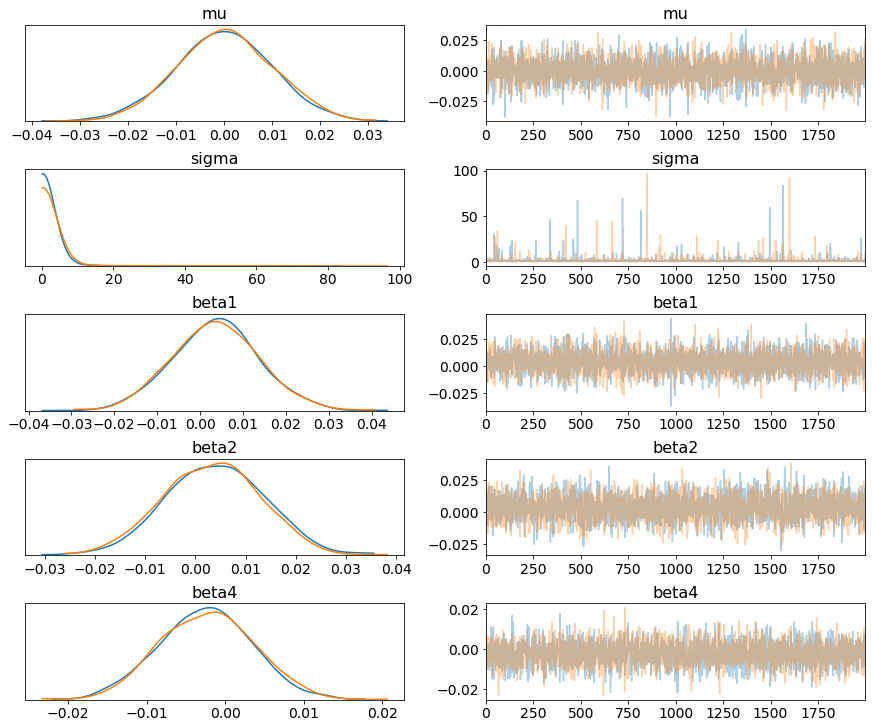

In [87]:

pm.traceplot(trace, compact=False, var_names=['mu','sigma','beta1','beta2','beta4'])


your response here

##### **A5**

Plot histograms of the posterior distributions for the parameters $\beta_{0,9}$, $\beta_{0,19}$, $\beta_{0,29}$, ..., $\beta_{0,59}$. Are the actual parameters that you generated contained within these posterior distributions? 

In [5]:
#your code here


your response here


##### **A6**

We now fit our model to the actual data. Fit the varying-intercept model to the real training data.

In [6]:
#your code here


##### **A7**

Check the convergence by examining the trace plots and R-hats, as you did with the simulated data. What do you observe?

In [7]:
#your code here


your response here

##### **A8**

Based on the posterior means, which district has the highest base rate of contraceptive usage (independent of other factors like urban population)? Which district has the lowest?

In [8]:
#your code here


your response here

##### **A9**

What are the posterior means of $\mu_0$ and $\sigma^2_0$? Do these values offer any evidence in support of or against the varying-intercept model, compared to a model with a single intercept value for all districts or a model with an intercept of 0 for all districts?

In [9]:
#your code here


your response here

### Part B: Varying-Coefficients Model

The next model we will fit to the contraceptives data is a varying-coefficients logistic regression model, where the coefficients on living.children, age-mean, and urban vary by district.

$\beta_{0j} \sim N(\mu_0,\sigma_0^2),$ with $\mu_0 \sim N(0,10000)$ and $\frac{1}{\sigma_0^2} \sim \text{Gamma}(0.1,0.1)$.

$\beta_{1j} \sim N(0,\sigma_1^2)$, with $\frac{1}{\sigma^2_1} \sim \text{Gamma}(0.1,0.1)$

$\beta_{2j}\sim N(0,\sigma_2^2)$, with $\frac{1}{\sigma^2_2}\sim \text{Gamma}(0.1,0.1)$

$\beta_{3j} \sim N(0,\sigma_3^2)$, with $\frac{1}{\sigma^2_3} \sim \text{Gamma}(0.1,0.1)$

Model for data:

$Y_{ij} \sim \text{Bernoulli}(p_{ij})$

$\text{logit}\:p_{ij} = \beta_{0j} + \beta_{1j} \times \text{urban} + \beta_{2j} \times \text{living.children} + \beta_{3j} \times \text{age-mean}$,

##### **B1**

Fit the model to the real data. Plot posterior means for each of the coefficients to the predictors. What do you conclude from these graphs?

In [10]:
#your code here


your response here

##### **B2**

Use all of the information you've gleaned thus far to build a final Bayesian logistic regression classifier on the train set. Then, use your model to make predictions on the test set. Report your model's classification percentage.

In [11]:
#your code here


your response here